### Exploratory analysis of Sentinel2 and ESA World Cover (labels) for the AOI2

In [21]:
import numpy as np
import rasterio
from rasterio import plot
import warnings
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os, glob, functools, fnmatch, requests,  io, shutil, tarfile, json
from tqdm import tqdm
from rasterio.merge import merge
from IPython.display import Image
import earthpy.plot as epp
import re
from labels import *
import earthpy.plot as ep

import patchify

In [2]:
# Set path to data and labels

DIR_data = '/Users/noeliaotero/Documents/Geo_analysis/data/AOI2/data/'
DIR_labes = '/Users/noeliaotero/Documents/Geo_analysis/data/AOI2/labels/'

In [3]:
# Read data
image_names = glob.glob(DIR_data + "*.tif")
# order names
image_names.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
label_names = glob.glob(DIR_labes + "*.tif")
# order names
label_names.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])


#### Define ESA Land cover classes and colors

In [4]:
class_names = ['nodata',
    'Tree cover',
   'Shrubland',
   'Grassland',
   'Cropland',
   'Built-up',
   'Bare / sparse vegetation',
   'Snow and ice',
   'Permanent water bodies',
   'Herbaceous wetland',
   'Mangroves',
   'Moss and lichen']

# Define the custom colors for the color map
colors = [ '#1f77b4','#006400', '#ffbb22ff', '#ffff4c', '#f096ff', '#fa0000', '#b4b4b4', '#f0f0f0', '#0064c8', '#0096a0', '#00cf75', '#fae6a0']

values = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100]
# Create a ListedColormap object with the custom colors
cmap_esa = ListedColormap(colors)

# Or we can use a dic
label_dic = {0:'nodata', 10:'Tree cover', 20:'Shrubland', 30:'Grassland', 40:'Cropland',50: 'Built-up', 60:'Bare / sparse vegetation', 70: 'Snow and ice', 
             80:'Permanent water bodies',90:'Herbaceous wetland', 95:'Mangroves', 100: 'Moss and lichen'}

### First exploration : Visualize data and label

In [5]:
# Open one image and corresponding label
img = rasterio.open(image_names[0]).read()
lab = rasterio.open(label_names[0]).read()
print(img.shape)
print(lab.shape)

(4, 5888, 5888)
(1, 5888, 5888)


In [6]:
def scale_img(img):
    """ Scale the image (RGB+NIR)"""
    # Normalize the data to [0, 1] range
    img = img.astype('float32')
    img /= np.max(img, axis=0)

    # Create a RGB + NIR composite
    rgb = img[:3,:,:].transpose(1,2,0)
    nir = img[3,:,:]
    rgb_nir = np.concatenate((rgb, np.expand_dims(nir, axis=2)), axis=2)
    return rgb_nir


In [7]:
# Open image and label
def vis_patch(image, mask, add_legend=True):
    """Plotting function of an image along with the corresponding label"""
    
    f, ax = plt.subplots(1, 2, figsize=(8, 8))

    rgb_nir = scale_img(image)
    ax[0].imshow(rgb_nir)
   
    im = ax[1].imshow(np.transpose(mask, (1,2,0)), cmap=cmap_esa)
    
    if add_legend:
        # Add the colorbar to the plot
        #im = ax[1].imshow(np.transpose(mask, (1,2,0)), cmap=cmap_esa)

        # Add a color bar with the class labels
        colorbar = f.colorbar(im, ax=ax[1], ticks=values)
        colorbar.ax.set_yticklabels(class_names, fontsize=8)
        colorbar.ax.tick_params(labelsize=8)
        colorbar.ax.set_ylabel('Class', fontsize=10)

        # Adjust the size of the colorbar
        colorbar.ax.set_position([0.95, 0.25, 0.02, 0.5])


# Show the plot
plt.show()
    

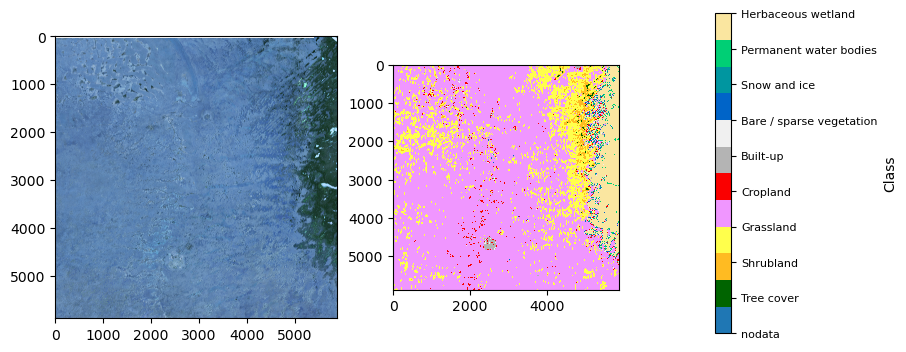

In [8]:
vis_patch(img, lab)

In [9]:
def plot_overlay(img, mask):
  """ Plot the image, the mask and overlay """
  
  # Create a figure and axes
  fig, axs = plt.subplots(1,3, figsize=(12,4))

  # Display the sat image
  rgb_nir = scale_img(img)
  axs[0].imshow(rgb_nir)
  axs[0].set_title("Sat Image")
  axs[0].axis('off')

  # Display the mask
  axs[1].imshow(np.transpose(mask, (1,2,0)),cmap= cmap_esa)
  axs[1].set_title("Mask")
  axs[1].axis('off')

  # Display the mask over the sat image
  axs[2].imshow(np.transpose(img, (1,2,0)))
  axs[2].imshow(np.transpose(mask, (1,2,0)), alpha=0.2)
  axs[2].set_title("Overlay")
  axs[2].axis('off')

  # show the plot
  plt.show()

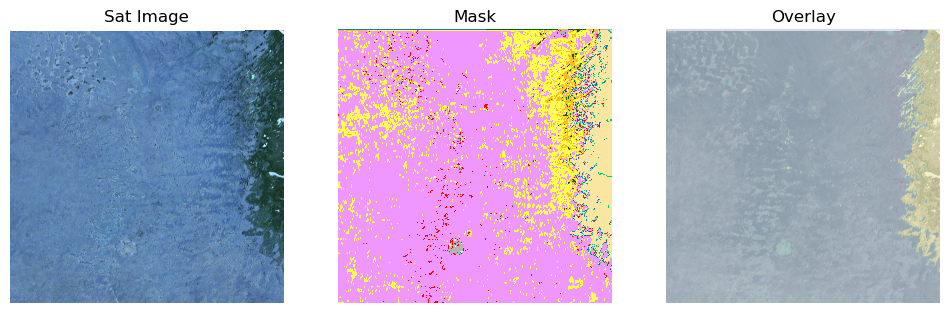

In [10]:
plot_overlay(img, lab)

### Labels frequency analysis:
##### There are 24 raster.tif. The frequency analysis are performed over each raster and then averaging over the whole set of tif.

In [12]:
def plot_lab_occurences(lab, ax=None):
    values, occurences = np.unique(lab, return_counts=True)
    #print(values, occurences)  # Print the values and occurrences arrays
    occurences = occurences / occurences.sum() * 100
    l_names = [label_dic[val] for val in values if not np.isnan(val)]
    #values_colors = label_to_rgb(values.reshape(-1, 1)).squeeze()
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    ax.bar(x=l_names, height=occurences, color=colors, width=0.6)
    ax.set_title('\nLand cover')
    ax.set_ylabel('Coverage (%)')
    ax.set_xticklabels(l_names, rotation=45, ha='right')
    if ax is None:
        plt.show()


In [13]:
#Calculate occurrence for each patch and means
df_occur = []

# create a list of all possible classes
all_classes = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100]


for i, label_name in enumerate(label_names):
    lab = rasterio.open(label_name).read() 
    vals, occurences = np.unique(lab, return_counts=True)
    occurences = occurences / occurences.sum() * 100
    c_name = 'RASTER_'+ str(i)
    df_freq = pd.DataFrame({'class':vals})
    df_tmp = pd.DataFrame(occurences)
    df_freq.insert(1, c_name, df_tmp.values)
    # reindex the data frame to include all possible classes
    filled_df = df_freq.set_index('class').reindex(all_classes, fill_value=0).reset_index()
    filled_df.reset_index()
    df_occur.append(filled_df)
    # concatenate data frames horizontally
# Merged   
merged_df = pd.concat(df_occur, axis=1)
# drop duplicate "class" columns (if any)
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]
# compute row means and add a new column
merged_df['row_means'] = merged_df.mean(axis=1)
# add class names
merged_df['class_name'] = class_names

In [14]:
print(merged_df)

    class   RASTER_0   RASTER_1   RASTER_2   RASTER_3   RASTER_4   RASTER_5  \
0       0   0.306843   0.063660   0.023647   0.188609   0.000000   0.000000   
1      10   0.744410   0.374322   2.558893   0.716376   0.198364   0.134367   
2      20   3.279324   0.879232   6.720152   4.271624   4.638306   1.389608   
3      30  85.554072  15.316374  50.091968  88.389910  85.353403  67.053898   
4      40   0.869996   0.071653   0.256025   0.267661   8.797200  23.742641   
5      50   0.343755   0.141690   0.527807   0.118070   0.045119   0.388626   
6      60   0.579739   0.048828   0.633476   0.758610   0.039863   0.286447   
7      70   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
8      80   0.139792  13.429658  13.616479   0.173059   0.000317   0.051358   
9      90   8.182068  69.674582  25.571553   5.116082   0.927429   6.953055   
10     95   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
11    100   0.000000   0.000000   0.000000   0.00000

### Plot occurence of each class calculated over the all patches


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


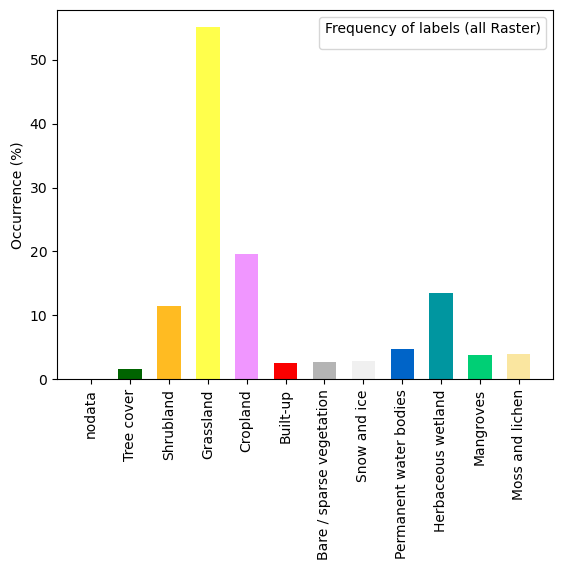

In [15]:
fig, ax = plt.subplots()

ax.bar(x=class_names, height=merged_df['row_means'], color=colors, width=0.6)
ax.set_ylabel('Occurrence (%)')
plt.xticks(rotation=90)
ax.legend(title='Frequency of labels (all Raster)')
plt.show()

### Plot the frequency of each class for each patch (i.e. RASTER_0...RASTER_4)

/var/folders/3p/7044wnn96f970j23ks8v97240000gn/T/ipykernel_47656/3158297861.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(l_names, rotation=45, ha='right')


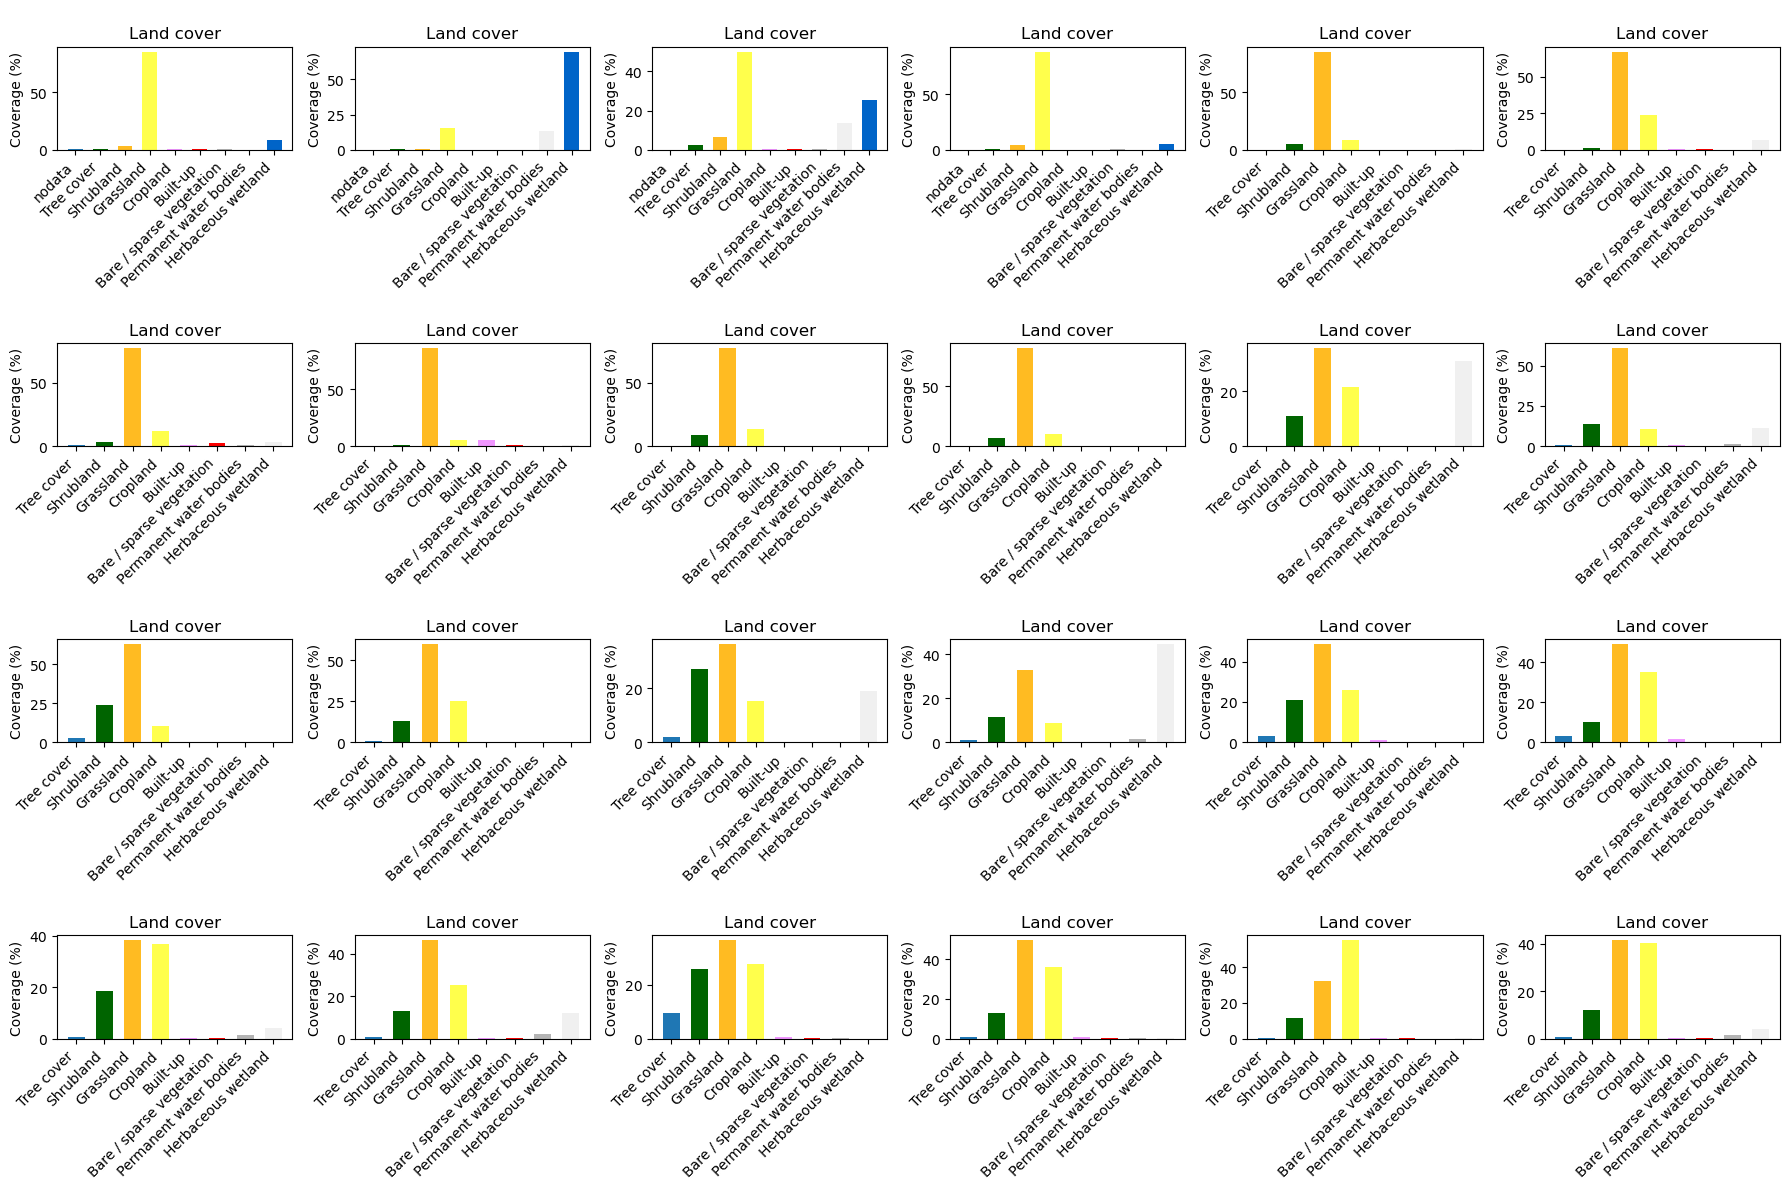

In [16]:
# Plot classes for each raster
fig, axs = plt.subplots(4, 6, figsize=(18, 12))
for i, label_name in enumerate(label_names):
    lab = rasterio.open(label_name).read()  # Read the label raster file
    row = i // 6  # Compute the row index of the subplot
    col = i % 6  # Compute the column index of the subplot
    ax = axs[row, col]  # Select the subplot corresponding to the current 
    plot_lab_occurences(lab, ax)
plt.tight_layout()  # Adjust the layout of the subplots
plt.show()  

#### EDA for images

In [14]:
image_names[0:2]

['/Users/noeliaotero/Documents/Geo_analysis/data/AOI2/data/RASTER_0.tif',
 '/Users/noeliaotero/Documents/Geo_analysis/data/AOI2/data/RASTER_1.tif']

In [17]:
for tif_file in image_names[0:1]:
    # Open the file using Rasterio
    with rasterio.open(tif_file) as src:
      # Read the raster bands
      red = src.read(1)
      green = src.read(2)
      blue = src.read(3)
      nir = src.read(4)
      # Stack the bands into a single 3D array
      img_stack = np.dstack((red, green, blue, nir))

      # Plot the histograms of all four bands in a single plot using EarthPy
      ep.hist(img_stack, bins=50, colors=['red', 'green', 'blue', 'magenta'],
              xlabel='Pixel Value', ylabel='Frequency',
              alpha=0.5, figsize=(12,6))
      # Add a legend to the plot
      plt.legend(['Red', 'Green', 'Blue', 'NIR'])




#### Explore correlations: We can explore the correlations between different bands

In [ ]:
with rasterio.open(image_names[0]) as src:
    red_band = src.read(4) # Read the red band
    nir_band = src.read(8) # Read the NIR band
    plt.scatter(red_band.flatten(), nir_band.flatten())
    plt.title('Red vs NIR Band Scatter Plot')
    plt.xlabel('Red Band Pixel Value')
    plt.ylabel('NIR Band Pixel Value')
    plt.show()